# Data preprocessing

In [1]:
import csv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score

data = []
scaler = MinMaxScaler()

def create_dataset(dataset, look_back=12):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        aux = dataset[i:(i+look_back)]
        dataX.append(aux)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

with open('./datasets/traffic-prediction-dataset.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)
    for row in csv_reader:
        row_to_append = [float(x) for x in row[0:4]]
        data.append(row_to_append)

scaler.fit(data)
normalized_data = scaler.transform(data)

/home/paolo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Train and Test Sets

In [2]:
train_size = int(len(normalized_data) * 0.75)
test_size = len(normalized_data) - train_size

train, test = normalized_data[0:train_size,:], normalized_data[train_size:len(normalized_data),:]
x_train, y_train = create_dataset(train)
x_test, y_test = create_dataset(test)
y_real = scaler.inverse_transform(y_test)

# Recurrent Neural Networks

In [3]:
train_rnn_size = int(len(x_train)*0.95)

x_train_rnn, y_train_rnn = x_train[0:train_rnn_size,:], y_train[0:train_rnn_size,:]
x_val_rnn, y_val_rnn = x_train[train_rnn_size:len(x_train),:], y_train[train_rnn_size:len(y_train),:]

## Training LSTM-NN

In [16]:
from keras import Input
from keras.models import Sequential 
from keras.layers import Dense, Dropout, InputLayer
from keras.layers import LSTM
from keras.callbacks import History 

history_lstm = History()


lstm_model = Sequential()
lstm_model.add(InputLayer(input_shape=(12, 4)))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(4))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')
lstm_model.summary()

lstm_model.fit(x_train_rnn, y_train_rnn, epochs=50, batch_size=128, validation_data=(x_val_rnn, y_val_rnn), callbacks=[history_lstm])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 64)            17664     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 50,948
Trainable params: 50,948
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
90/90 [==============================] - 4s 21ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 2/50
90/90 [==============================] - 1s 17ms/step - loss: 0.0048 - v

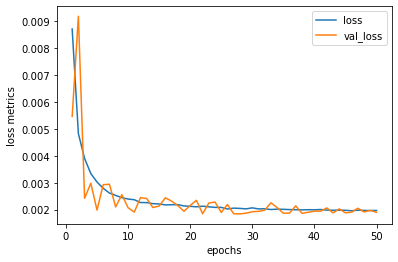

In [34]:
import matplotlib.pyplot as plt

epochs = [i+1 for i in range(50)]
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

plt.plot(epochs, loss_lstm)
plt.plot(epochs, val_loss_lstm)
plt.xlabel("epochs")
plt.ylabel("loss metrics")
plt.legend(['loss', 'val_loss'])
plt.savefig("loss_lstm.jpg")

## Testing LSTM-NN

In [25]:
y_pred_lstm = lstm_model.predict(x_test)

y_real_pred_lstm = scaler.inverse_transform(y_pred_lstm)
 
print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_lstm))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_lstm))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_lstm, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_lstm))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_lstm))

126/126 [==============================] - 1s 5ms/step
Mean Absolute error: 10.825328745745061
Mean Absolute Percentage error: 921925219624300.1
Mean Squared error: 15.833685012283713
R-Squared score: 0.9300004819342713
Explained Variance score: 0.9307716447480484


## Training GRU-NN

In [35]:
from keras.layers import GRU

history_gru = History()

gru_model = Sequential()
gru_model.add(InputLayer(input_shape=(12, 4)))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(4))
gru_model.compile(loss='mean_squared_error', optimizer='rmsprop')
gru_model.summary()

gru_model.fit(x_train_rnn, y_train_rnn, epochs=50, batch_size=128, validation_data=(x_val_rnn, y_val_rnn), callbacks=[history_gru])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 12, 64)            13440     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 38,660
Trainable params: 38,660
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
90/90 [==============================] - 4s 20ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 2/50
90/90 [==============================] - 1s 15ms/step - loss: 0.0034 - v

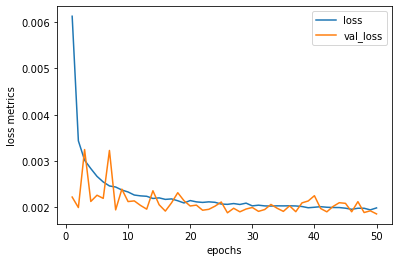

In [36]:
epochs = [i+1 for i in range(50)]
loss_gru = history_gru.history['loss']
val_loss_gru = history_gru.history['val_loss']

plt.plot(epochs, loss_gru)
plt.plot(epochs, val_loss_gru)
plt.xlabel("epochs")
plt.ylabel("loss metrics")
plt.legend(['loss', 'val_loss'])
plt.savefig("loss_gru.jpg")

## Testing GRU-NN

In [30]:
y_pred_gru = gru_model.predict(x_test)

y_real_pred_gru = scaler.inverse_transform(y_pred_gru)
 
print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_gru))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_gru))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_gru, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_gru))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_gru))

126/126 [==============================] - 1s 5ms/step
Mean Absolute error: 11.280484681992121
Mean Absolute Percentage error: 1563710217145945.0
Mean Squared error: 16.333450336774902
R-Squared score: 0.9251373812182374
Explained Variance score: 0.9270541875009984


# Machine Learning Models

In [5]:
def array3dto2d(array):
    return array.reshape(array.shape[0], (array.shape[1]*array.shape[2]))

x_train2d = array3dto2d(x_train)
x_test2d = array3dto2d(x_test)

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

linear_regression_model = LinearRegression().fit(x_train2d, y_train)
linear_regression_prediction = linear_regression_model.predict(x_test2d)

y_real_pred_lr = scaler.inverse_transform(linear_regression_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_lr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_lr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_lr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_lr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_lr))

Mean Absolute error: 10.995112992690943
Mean Absolute Percentage error: 1215443375208624.8
Mean Squared error: 15.964060260773927
R-Squared score: 0.9287586530693062
Explained Variance score: 0.9292343641817418


## Gradient Boosting Regressor

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gradient_boosting_regressor_model = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(x_train2d, y_train)
gradient_boosting_regressor_prediction = gradient_boosting_regressor_model.predict(x_test2d)

y_real_pred_gbr = scaler.inverse_transform(gradient_boosting_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_gbr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_gbr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_gbr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_gbr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_gbr))

Mean Absolute error: 11.017974318566079
Mean Absolute Percentage error: 741872148482966.4
Mean Squared error: 16.329491974927954
R-Squared score: 0.9260844119027556
Explained Variance score: 0.9266281566391708


## MultiLayer Perceptron Regressor

In [13]:
from sklearn.neural_network import MLPRegressor

mlp_regressor_model = MLPRegressor(random_state=0).fit(x_train2d, y_train)
mlp_regressor_prediction = mlp_regressor_model.predict(x_test2d)

y_real_pred_mlpr = scaler.inverse_transform(mlp_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_mlpr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_mlpr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_mlpr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_mlpr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_mlpr))

Mean Absolute error: 11.364891533088883
Mean Absolute Percentage error: 1517729348770284.0
Mean Squared error: 16.406624394242687
R-Squared score: 0.9238183799802224
Explained Variance score: 0.9258635803959911


## Stochastic Gradient Descendent Regressor

In [14]:
from sklearn.linear_model import SGDRegressor

sgd_regressor_model = MultiOutputRegressor(SGDRegressor(random_state=0)).fit(x_train2d, y_train)
sgd_regressor_prediction = sgd_regressor_model.predict(x_test2d)

y_real_pred_sgdr = scaler.inverse_transform(sgd_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_sgdr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_sgdr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_sgdr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_sgdr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_sgdr))

Mean Absolute error: 12.187349624612459
Mean Absolute Percentage error: 2803388624268320.0
Mean Squared error: 17.980527117240715
R-Squared score: 0.9068198160471619
Explained Variance score: 0.9110625297566236


## Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor_model = RandomForestRegressor(random_state=0).fit(x_train2d, y_train)
random_forest_regressor_prediction = random_forest_regressor_model.predict(x_test2d)

y_real_pred_rfr = scaler.inverse_transform(random_forest_regressor_prediction)

print("Mean Absolute error:", mean_absolute_error(y_real, y_real_pred_rfr))
print("Mean Absolute Percentage error:", mean_absolute_percentage_error(y_real, y_real_pred_rfr))
print("Mean Squared error:", mean_squared_error(y_real, y_real_pred_rfr, squared=False))
print("R-Squared score:", r2_score(y_real, y_real_pred_rfr))
print("Explained Variance score:", explained_variance_score(y_real, y_real_pred_rfr))

Mean Absolute error: 12.28977345857269
Mean Absolute Percentage error: 3937009837481399.0
Mean Squared error: 19.080446960903608
R-Squared score: 0.8865108967363967
Explained Variance score: 0.8889978198000288
